<a href="https://colab.research.google.com/github/flyingraijin98/Polynomial_Regression_project/blob/main/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras-conv-visualizer
!pip install plot-metric

In [1]:
import os
import cv2
import numpy as np
import keras
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

In [2]:
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, TimeDistributed, LSTM, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from plot_metric.functions import BinaryClassification
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle
from tabulate import tabulate
from matplotlib import cm

In [3]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [4]:
data_directory = "/content/drive/MyDrive/Violence Detection Dataset/Merged"
img_height,img_width = 224,224
seq_len = 4
classes = ["NonViolence", "Violence"]

In [5]:
fps=0
frame_count=0
duration=0

In [6]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    global fps 
    fps = vidObj.get(cv2.CAP_PROP_FPS)      
    global frame_count
    frame_count+= int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))
    global duration
    duration += frame_count/fps 
    count = 1
    total_frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
    frames_step = total_frames//seq_len
    for i in range(seq_len):
        vidObj.set(1,i*frames_step)
        success,image = vidObj.read()   
        if success:
            image = cv2.resize(image, (img_height, img_width))
            image = preprocess_input(image)
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
            
    return frames_list

In [7]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in tqdm(files_list):
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
    print("Frames per second:",fps)
    print("Average number of frames in a video: ",frame_count/4000) 
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_directory)

Violence


100%|██████████| 2000/2000 [07:44<00:00,  4.31it/s]


NonViolence


100%|██████████| 2000/2000 [02:52<00:00, 11.59it/s]


Frames per second: 29.0
Average number of frames in a video:  146.84225


In [8]:
np.save('/content/drive/MyDrive/Violence Detection Dataset/X_224_224_4_resnet',X)
np.save('/content/drive/MyDrive/Violence Detection Dataset/Y_224_224_4_resnet',Y)

In [9]:
X=np.load('/content/drive/MyDrive/Violence Detection Dataset/X_224_224_4_resnet.npy')
Y=np.load('/content/drive/MyDrive/Violence Detection Dataset/Y_224_224_4_resnet.npy')

In [ ]:
X,y = shuffle(X,Y, random_state=42)
print("The shape of input is : ",np.shape(X))
print("The shape of target is : ", np.shape(y))

The shape of input is :  (4000, 10, 112, 112, 3)
The shape of target is :  (4000, 2)


In [12]:
SIZE = (224,224)
CHANNELS = 3
NBFRAME = 5
INSHAPE=(NBFRAME,) + SIZE+ (CHANNELS,)

splits=5
skf = StratifiedKFold(n_splits=splits, shuffle=False)
y=np.argmax(y,axis=1)

NameError: ignored

In [ ]:
def build_resnet(shape=(112, 112, 3), nbout=2):
    model = Sequential([preprocessing.Rescaling(1.0 / 255),
                              preprocessing.RandomFlip("horizontal"),
                              preprocessing.RandomFlip("vertical"),
                              preprocessing.RandomRotation(0.1),
                              preprocessing.RandomZoom(0.1)])

    model.add(ResNet50(include_top=False,input_shape=shape,weights='imagenet'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    output = GlobalAveragePooling2D()
    return Sequential([model, output])

In [ ]:
def resnet_lstm_model(shape=(NBFRAME,112,112,3), nbout=2):
    resnet = build_resnet(shape[1:])
    model = Sequential()
    model.add(TimeDistributed(resnet, input_shape=shape))
    model.add(LSTM(64))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = False)

model_resnet = resnet_lstm_model(INSHAPE)
model_resnet.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 2048)          23595904  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                540928    
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 24,205,442
Trainable params: 24,148,226
Non-trainable params: 57,216
_________________________________________________________________


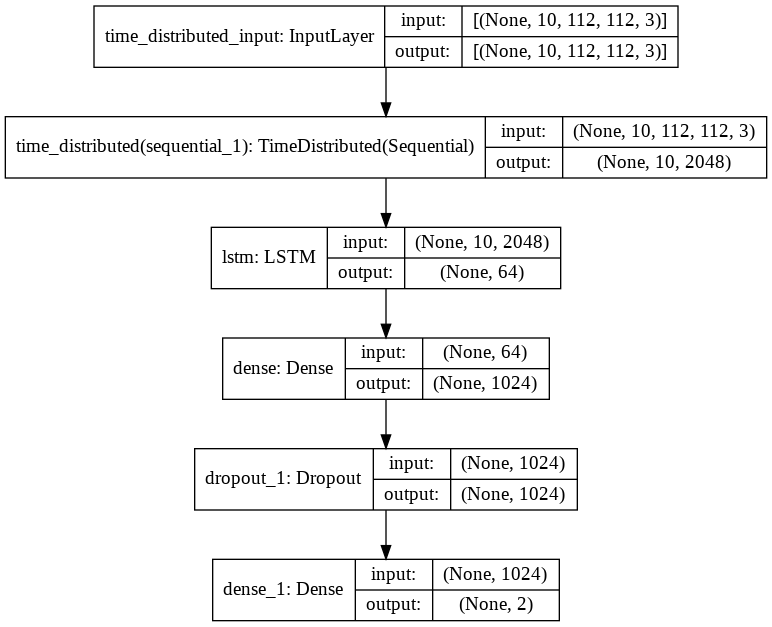

In [ ]:
plot_model(model_resnet,show_shapes=True,expand_nested=False)

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
training_loss=[]
training_accu=[]
valid_accu=[]
valid_loss=[]
pred_targets=[]
Y_test_pf=[]
fold=1
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_train=np.asarray(pd.get_dummies(y_train))
  y_test=np.asarray(pd.get_dummies(y_test))
  
  model_resnet = resnet_lstm_model(INSHAPE)
  optimizer = optimizers.Adam(1e-5)
  model_resnet.compile(optimizer,'categorical_crossentropy',metrics=['acc'])
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("For Fold {}".format(fold))
  history = model_resnet.fit(x=X_train, y=y_train, epochs=40, batch_size = 8,validation_split=0.125,callbacks = [early_stopping_callback])
  print()
  print("Evaluating the model for the Fold {}".format(fold))
  model_evaluation_history = model_resnet.evaluate(X_test,y_test)
  pred_targets.append(model_resnet.predict(X_test))
  
  training_accu.append(history.history['acc'])
  training_loss.append(history.history['loss'])
  valid_accu.append(history.history['val_acc'])
  valid_loss.append(history.history['val_loss'])
  Y_test_pf.append(y_test)
  fold += 1

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
For Fold 1
Epoch 1/40
350/350 [==============================] - 88s 186ms/step - loss: 0.6792 - acc: 0.5657 - val_loss: 0.6852 - val_acc: 0.5575
Epoch 2/40
350/350 [==============================] - 64s 182ms/step - loss: 0.6156 - acc: 0.7011 - val_loss: 0.5736 - val_acc: 0.7000
Epoch 3/40
350/350 [==============================] - 64s 182ms/step - loss: 0.5135 - acc: 0.7800 - val_loss: 0.4671 - val_acc: 0.7850
Epoch 4/40
350/350 [==============================] - 64s 182ms/step - loss: 0.4474 - acc: 0.7975 - val_loss: 0.4171 - val_acc: 0.8050
Epoch 5/40
350/350 [==============================] - 64s 182ms/step - loss: 0.3771 - acc: 0.8389 - val_loss: 0.3827 - val_acc: 0.8200
Epoch 6/40
350/350 [================

In [ ]:
model_resnet.save('/content/drive/MyDrive/Violence Detection Dataset/ResNet_LSTM_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
kkkk=keras.models.load_model('/content/drive/MyDrive/Violence Detection Dataset/ResNet_LSTM_model.h5')

#**Resnet50 + LSTM :**


##**Results:**

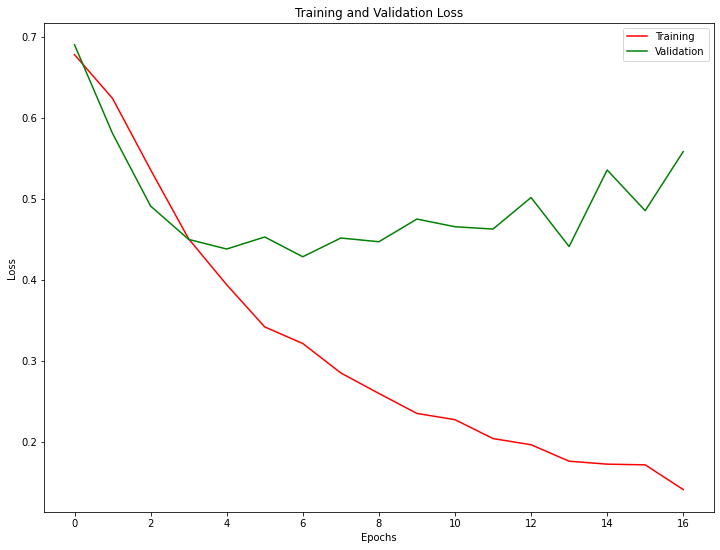

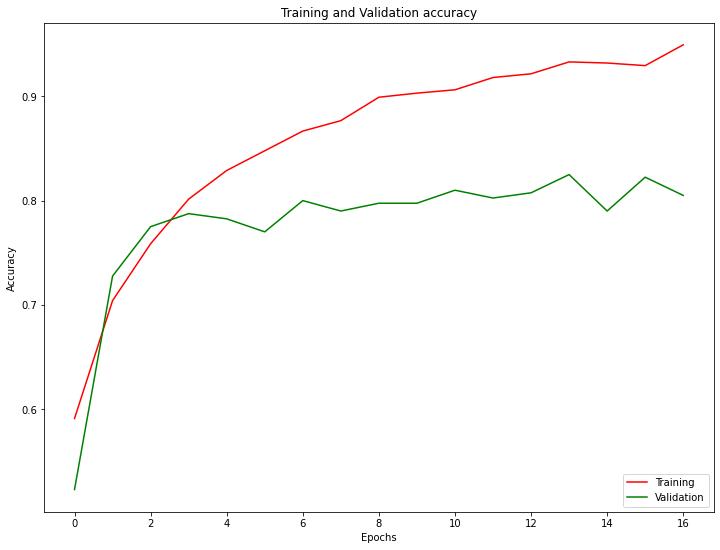

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.title('Training and Validation Loss')
plt.legend(["Training","Validation"])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

plt.figure(figsize=(12,9))
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.title('Training and Validation accuracy')
plt.legend(["Training","Validation"],loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 1
Correctly predicted out of 800:  653
Accuracy is                   :  0.81625
F1-score is                   :  0.8196319018404908
Recall score is               :  0.835
Precision score is            :  0.8048192771084337
False Positive Rate           :  0.2025
False Negative Rate           :  0.165
Area under the curve of ROC is:  0.90533125

Report
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       400
           1       0.80      0.83      0.82       400

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



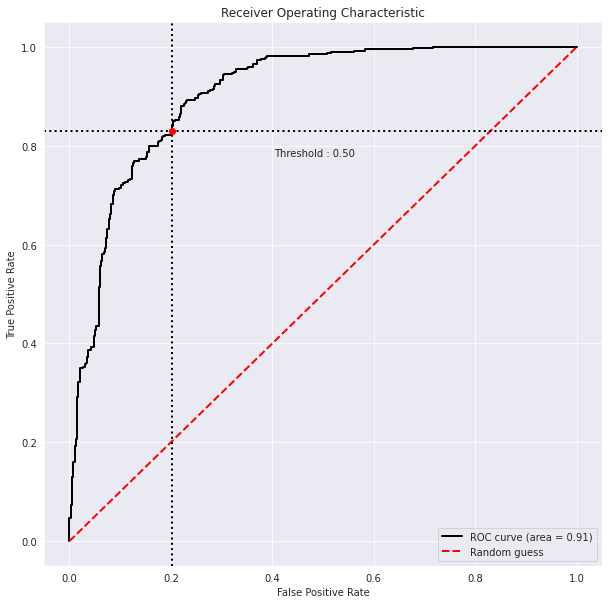

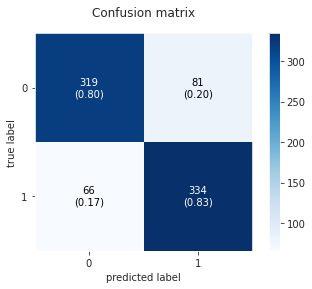

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 2
Correctly predicted out of 800:  663
Accuracy is                   :  0.82875
F1-score is                   :  0.8331303288672351
Recall score is               :  0.855
Precision score is            :  0.8123515439429929
False Positive Rate           :  0.1975
False Negative Rate           :  0.145
Area under the curve of ROC is:  0.909496875

Report
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       400
           1       0.81      0.85      0.83       400

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



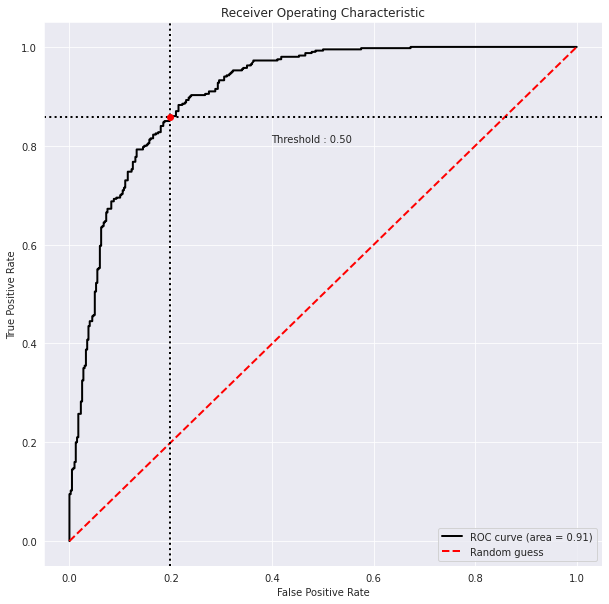

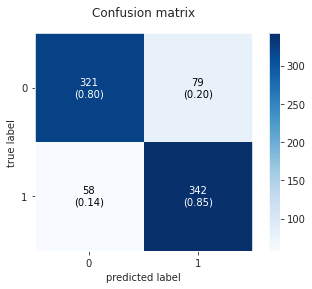

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 3
Correctly predicted out of 800:  679
Accuracy is                   :  0.84875
F1-score is                   :  0.8493150684931506
Recall score is               :  0.8525
Precision score is            :  0.8461538461538461
False Positive Rate           :  0.155
False Negative Rate           :  0.1475
Area under the curve of ROC is:  0.9280437500000001

Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       400
           1       0.85      0.85      0.85       400

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



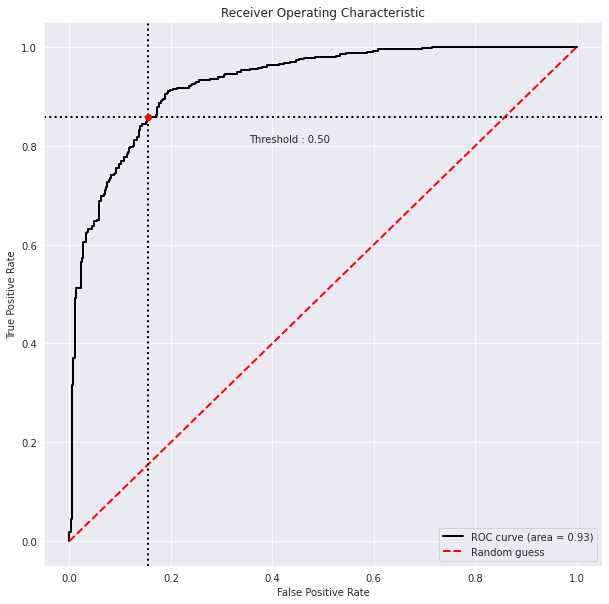

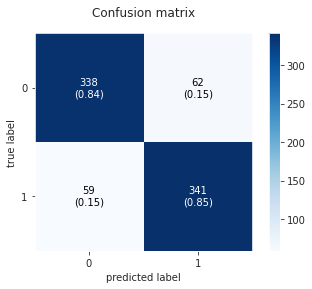

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 4
Correctly predicted out of 800:  654
Accuracy is                   :  0.8175
F1-score is                   :  0.8302325581395348
Recall score is               :  0.8925
Precision score is            :  0.7760869565217391
False Positive Rate           :  0.2575
False Negative Rate           :  0.1075
Area under the curve of ROC is:  0.91280625

Report
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       400
           1       0.78      0.89      0.83       400

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



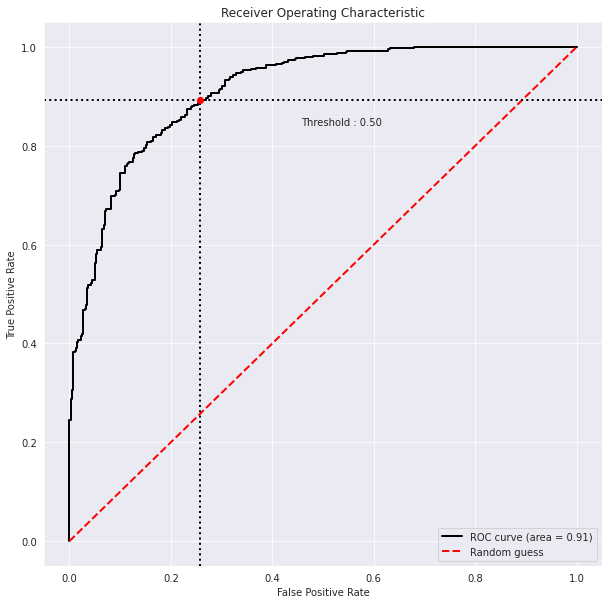

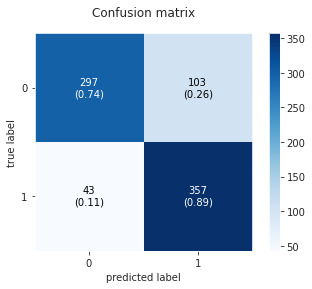

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 5
Correctly predicted out of 800:  662
Accuracy is                   :  0.8275
F1-score is                   :  0.8193717277486912
Recall score is               :  0.7825
Precision score is            :  0.8598901098901099
False Positive Rate           :  0.1275
False Negative Rate           :  0.2175
Area under the curve of ROC is:  0.91876875

Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       400
           1       0.86      0.78      0.82       400

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



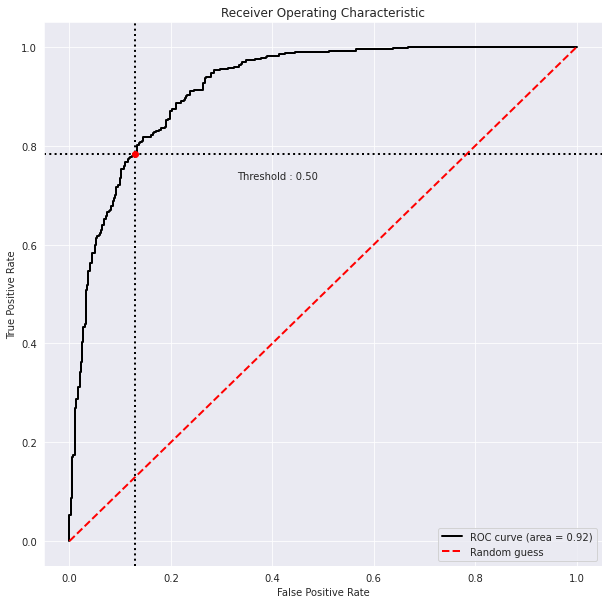

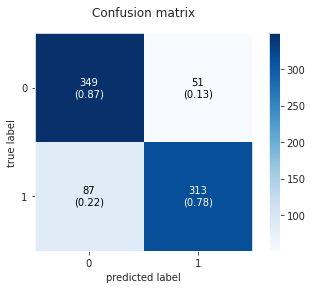

In [ ]:
avg_accuracy=0
avg_recall=0
avg_precision=0
avg_f1=0
avg_fpr=0
avg_fnr=0
table=[]
for i in range(splits):
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("For Fold {}".format(i+1))
  
  y_pred=pred_targets[i]
  y_prob=y_pred
  y_pred=np.argmax(y_pred,axis=1)
  Y_test=np.argmax(Y_test_pf[i],axis=1)
  conf_mat=confusion_matrix(Y_test,y_pred)
  table.append(["Fold {}".format(i+1),accuracy_score(Y_test,y_pred),f1_score(Y_test,y_pred),recall_score(Y_test,y_pred),precision_score(Y_test,y_pred),conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0]),conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1])])
  avg_accuracy+=accuracy_score(Y_test,y_pred)
  avg_recall +=recall_score(Y_test,y_pred)
  avg_precision +=precision_score(Y_test,y_pred)
  avg_f1 += f1_score(Y_test,y_pred)
  avg_fpr += conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0])
  avg_fnr += conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1])

  print("Correctly predicted out of 800: ",sum(Y_test==y_pred))
  print("Accuracy is                   : ",accuracy_score(Y_test,y_pred))
  print("F1-score is                   : ",f1_score(Y_test,y_pred))
  print("Recall score is               : ", recall_score(Y_test,y_pred))
  print("Precision score is            : ", precision_score(Y_test,y_pred))
  print("False Positive Rate           : ", conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0]))
  print("False Negative Rate           : ", conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1]))
  print("Area under the curve of ROC is: ",roc_auc_score(Y_test,y_prob[:,1]))
  print()
  print("Report")
  print(classification_report(Y_test,y_pred))
  bc = BinaryClassification(Y_test, y_prob[:,1], labels=["Class 1", "Class 2"])
  plt.figure(figsize=(10,10))
  bc.plot_roc_curve()
  plt.show()
  fig, ax = plot_confusion_matrix(conf_mat,show_absolute=True,show_normed=True,colorbar=True)
  plt.title("Confusion matrix")
  plt.show()

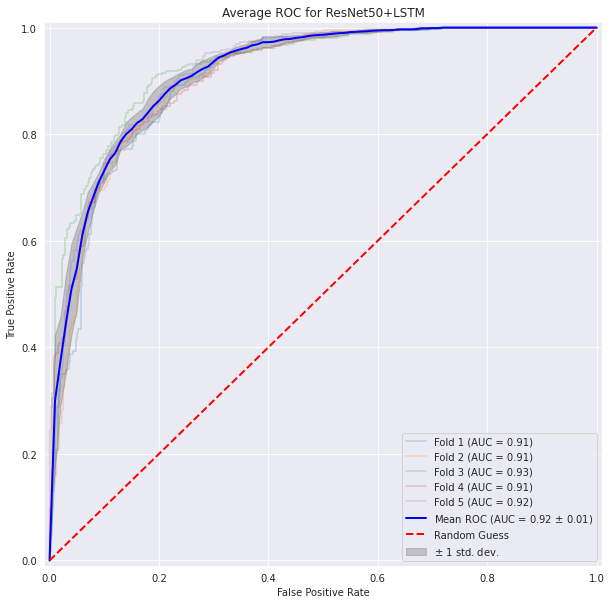

In [ ]:
from sklearn.metrics import auc
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(10,10))

for i in range(splits):
    y_prob=pred_targets[i]
    Y_test=np.argmax(Y_test_pf[i],axis=1)
    aucs.append(roc_auc_score(Y_test,y_prob[:,1]))
    fpr,tpr,_ = roc_curve(Y_test, y_prob[:,1])
    plt.plot(fpr, tpr, alpha=0.25, label=r'Fold %d (AUC = %0.2f)' % (i+1, aucs[-1]))
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = np.maximum(mean_tprs - std,0)

mean_auc=auc(mean_fpr, mean_tprs)
std_auc=np.std(aucs)
plt.plot(mean_fpr, mean_tprs, 'b',lw=2,label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.4,label=r'$\pm$ 1 std. dev.')
plt.title("Average ROC for ResNet50+LSTM")
plt.plot([0, 1], [0, 1],'r--',label='Random Guess',lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc="lower right")
plt.show()

In [ ]:
tbl=np.array(table)

In [ ]:
table.append(['Average',(avg_accuracy/splits),(avg_f1/splits),(avg_recall/splits),(avg_precision/splits),(avg_fpr/splits),(avg_fnr/splits)])
table.append(['Standard Deviation',np.std(tbl[:,1].astype('float32')),np.std(tbl[:,2].astype('float32')),np.std(tbl[:,3].astype('float32')),np.std(tbl[:,4].astype('float32')),np.std(tbl[:,5].astype('float32')),np.std(tbl[:,6].astype('float32'))])
print(tabulate(table,headers=["","Accuracy","F1-score","Recall","Precison","FPR","FNR"],tablefmt='github'))
print("")

|                    |   Accuracy |   F1-score |   Recall |   Precison |       FPR |      FNR |
|--------------------|------------|------------|----------|------------|-----------|----------|
| Fold 1             |  0.81625   |  0.819632  | 0.835    |  0.804819  | 0.2025    | 0.165    |
| Fold 2             |  0.82875   |  0.83313   | 0.855    |  0.812352  | 0.1975    | 0.145    |
| Fold 3             |  0.84875   |  0.849315  | 0.8525   |  0.846154  | 0.155     | 0.1475   |
| Fold 4             |  0.8175    |  0.830233  | 0.8925   |  0.776087  | 0.2575    | 0.1075   |
| Fold 5             |  0.8275    |  0.819372  | 0.7825   |  0.85989   | 0.1275    | 0.2175   |
| Average            |  0.82775   |  0.830336  | 0.8435   |  0.81986   | 0.188     | 0.1565   |
| Standard Deviation |  0.0116565 |  0.0109801 | 0.035798 |  0.0299748 | 0.0444522 | 0.035798 |



In [ ]:
def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

In [ ]:
#Gradcam for Violence videos
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
from keras_conv_visualizer.gradcam import GradCAM
import PIL
video_list=['/content/drive/MyDrive/Violence Detection Dataset/Merged/Violence/V_751.mp4',
            '/content/drive/MyDrive/Violence Detection Dataset/Merged/Violence/V_407.mp4']

for vid in video_list:
  frame_list=np.asarray(frames_extraction(vid))



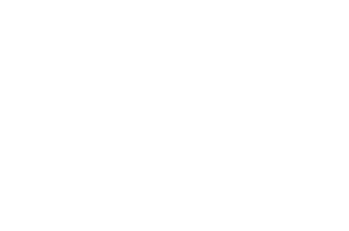

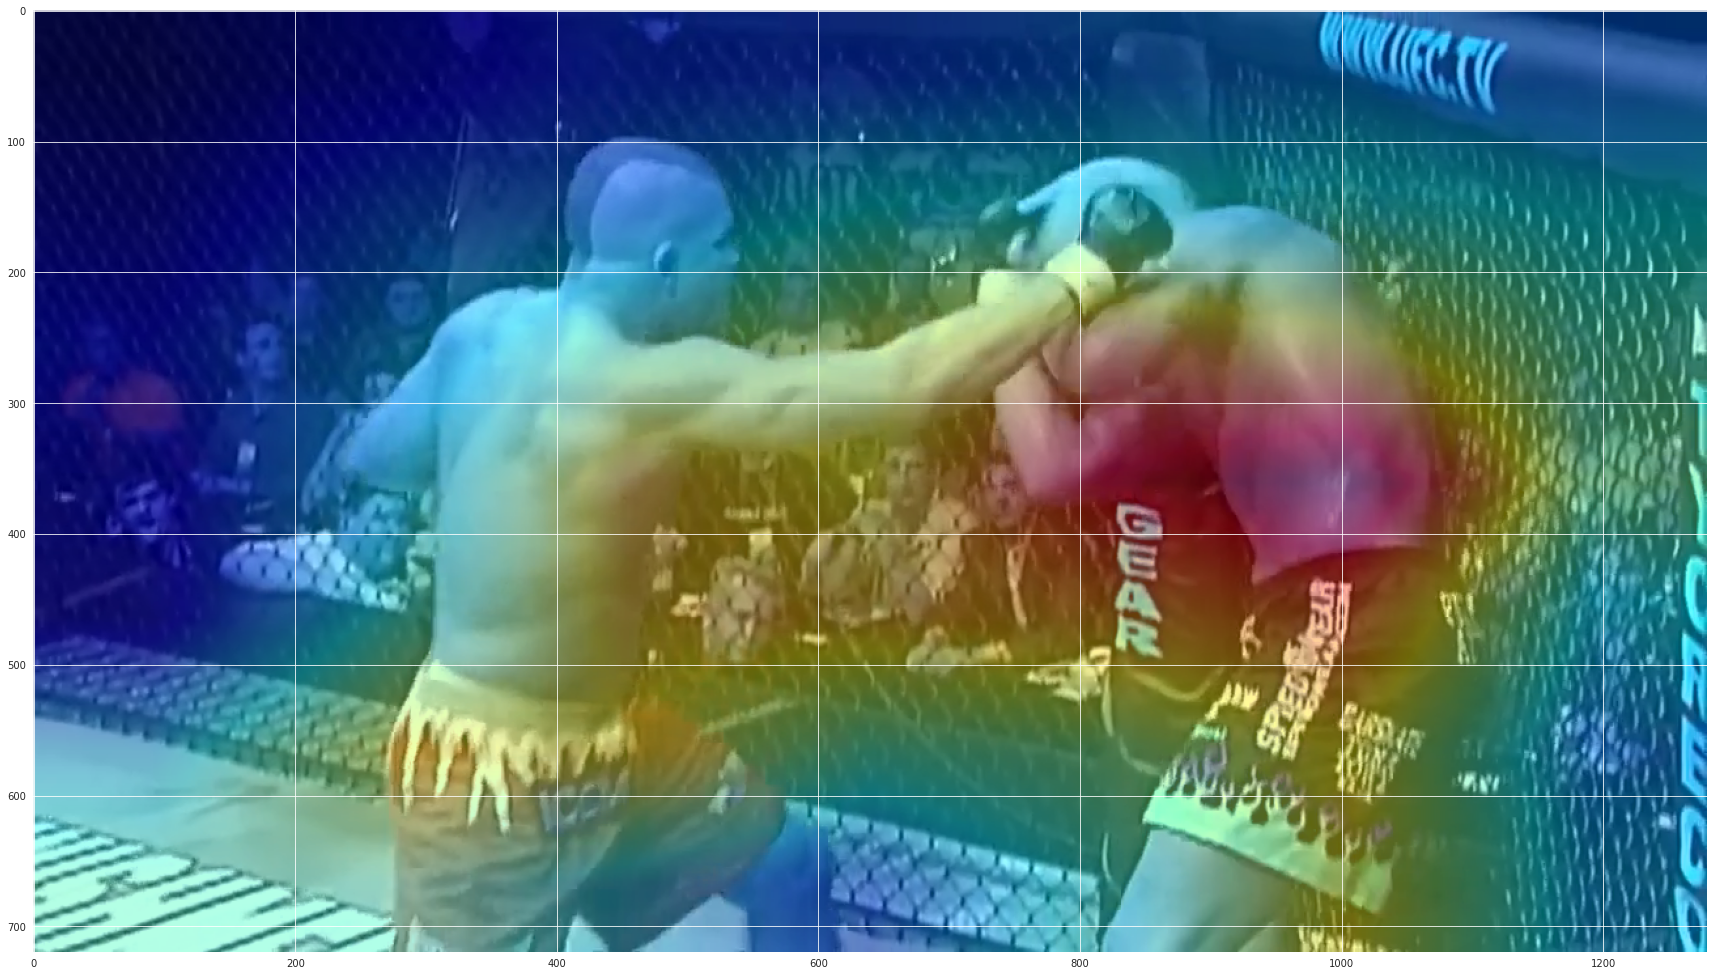

In [ ]:
image_path="/content/drive/MyDrive/Violence Detection Dataset/Violence Selected/vlcsnap-2021-05-23-01h09m15s674.png"

image = load_img(image_path, target_size=(224,224))
image = img_to_array(image)
image = imagenet_utils.preprocess_input(image)

cam = GradCAM(ResNet50(input_shape=(224,224,3),weights='imagenet'))
heatmap, output = cam.make_superimposed_img(image,image_path, alpha=0.6)
plt.axis('off')
plt.figure(figsize=(,30))
plt.imshow(heatmap)
plt.imshow(output)

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
ffs=CategoricalScore([1, 294, 413])

In [ ]:
ffs.shape

AttributeError: ignored